### This is a simple notebook to build, visualize, and diagnose the performance of DT algorithms on the (larger) habitable planets data set.

It accompanies Chapter 3 of the book.

Data for this exercise come from [here](http://phl.upr.edu/projects/habitable-exoplanets-catalog/data/database).

Author: Viviana Acquaviva

In [1]:
import pandas as pd

import numpy as np

import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
from io import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz

In [3]:
import matplotlib
font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rcParams['figure.dpi'] = 300

### Step 1: Preliminary data analysis/exploration.

Once we are working with research-level data sets, our first step should always be data exploration.

We can read the data in a data frame, as we did previously, and do some preliminary data analysis.

In [4]:
df = pd.read_csv('phl_exoplanet_catalog.csv', sep = ',')

In [5]:
df.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [6]:
df.columns

Index(['P_NAME', 'P_STATUS', 'P_MASS', 'P_MASS_ERROR_MIN', 'P_MASS_ERROR_MAX',
       'P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_RADIUS_ERROR_MAX', 'P_YEAR',
       'P_UPDATED',
       ...
       'P_HABZONE_CON', 'P_TYPE_TEMP', 'P_HABITABLE', 'P_ESI',
       'S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG',
       'P_RADIUS_EST', 'P_MASS_EST', 'P_SEMI_MAJOR_AXIS_EST'],
      dtype='object', length=112)

In [7]:
df.describe()

,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_PERIOD,P_PERIOD_ERROR_MIN,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_HABITABLE,P_ESI,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
count,4048.0,1598.000000,1467.000000,1467.000000,3139.000000,3105.000000,3105.000000,4048.000000,3.938000e+03,3.807000e+03,...,3786.000000,3.083000e+03,3281.000000,4048.000000,4048.000000,4048.000000,3721.000000,4048.000000,4048.000000,3978.000000
mean,3.0,798.384920,-152.292232,190.289692,4.191426,-0.483990,0.621867,2014.212945,2.309342e+03,-1.073631e+03,...,3.513348,1.768991e+35,0.440103,0.049654,0.034091,0.021986,0.261252,5.588647,323.089993,4.011385
std,0.0,1406.808654,783.366353,1082.061976,4.776830,1.409048,2.007592,3.704839,1.167012e+05,5.943181e+04,...,5.463171,6.944274e+36,0.074285,0.217256,0.181485,0.195731,0.131333,5.392733,965.084290,62.389968
min,3.0,0.019070,-24965.390000,0.000000,0.336300,-54.592700,0.000000,1989.000000,9.070629e-02,-3.650000e+06,...,0.002405,7.293660e-05,0.030707,0.000000,0.000000,0.000000,0.006768,0.000000,0.000000,0.004400
25%,3.0,26.548968,-79.457001,4.449592,1.569400,-0.526870,0.145730,2014.000000,4.497336e+00,-1.129000e-03,...,1.740762,5.264169e-01,0.420337,0.000000,0.000000,0.000000,0.196982,1.703920,3.628101,0.053000
50%,3.0,273.332080,-24.154928,25.108412,2.331680,-0.235410,0.325090,2016.000000,1.187053e+01,-9.392000e-05,...,2.568600,1.429118e+00,0.448357,0.000000,0.000000,0.000000,0.271192,2.667980,7.815324,0.102199
75%,3.0,806.488560,-4.392383,85.813561,3.553570,-0.134520,0.661390,2016.000000,4.186661e+01,-1.594000e-05,...,3.661581,2.641037e+00,0.472140,0.000000,0.000000,0.000000,0.303346,11.770500,149.379160,0.260507
max,3.0,17668.059000,0.270000,26630.808000,77.349000,0.450000,68.919080,2019.000000,7.300000e+06,3.200000e-02,...,104.112780,2.726899e+38,1.322542,1.000000,1.000000,2.000000,0.931208,77.349000,17668.059000,2500.000000


In [8]:
df.groupby('P_HABITABLE').count()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
P_HABITABLE,,,,,,,,,,,,,,,,,,,,,
0,3993,3993,1575,1444,1444,3101,3067,3067,3993,3993,...,3993,3993,3666,3666,3993,3993,3993,3993,3993,3923
1,21,21,16,16,16,9,9,9,21,21,...,21,21,21,21,21,21,21,21,21,21
2,34,34,7,7,7,29,29,29,34,34,...,34,34,34,34,34,34,34,34,34,34


#### Start by lumping together Probably and Possibly Habitable planets.

In [9]:
bindf = df.drop('P_HABITABLE', axis = 1) #What are we doing here? Creating a new data frame called bindf and droppoing the old habitability tag

In [10]:
bindf['P_HABITABLE'] = (np.logical_or((df.P_HABITABLE == 1) , (df.P_HABITABLE == 2))) #how about here? creating my new habitability tag
bindf['P_HABITABLE'] = bindf['P_HABITABLE'].astype(int) #and here? Re-casting this column as integer

In [11]:
bindf.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST,P_HABITABLE
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29,0
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53,0
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83,0
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93,0
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66,0


### Let's select some columns.

S_MAG - star magnitude 

S_DISTANCE - star distance (parsecs)

S_METALLICITY - star metallicity (dex)

S_MASS - star mass (solar units)

S_RADIUS - star radius (solar units)

S_AGE - star age (Gy)

S_TEMPERATURE - star effective temperature (K)

S_LOG_G - star log(g)

P_DISTANCE - planet mean distance from the star (AU) 

P_FLUX - planet mean stellar flux (earth units)

P_PERIOD - planet period (days) 

### We can select the same features as we did in Chapter 2.

In [12]:
final_features = bindf[['S_MASS', 'P_PERIOD', 'P_DISTANCE']] 

In [13]:
targets = bindf.P_HABITABLE

In [14]:
final_features.head()

,S_MASS,P_PERIOD,P_DISTANCE
0,2.70,326.03000,1.324418
1,2.78,516.21997,1.534896
2,2.20,185.84000,0.830000
3,0.90,1773.40000,3.130558
4,1.08,798.50000,2.043792


### There are some NaNs. We can see this by using the "describe" property, which only counts numerical values in each column.

In [15]:
final_features.shape

(4048, 3)

In [16]:
final_features.describe()

,S_MASS,P_PERIOD,P_DISTANCE
count,3283.000000,3.938000e+03,3978.000000
mean,1.003838,2.309342e+03,4.047677
std,0.652903,1.167012e+05,62.435994
min,0.010000,9.070629e-02,0.004408
25%,0.810000,4.497336e+00,0.053110
50%,0.970000,1.187053e+01,0.103000
75%,1.130000,4.186661e+01,0.263415
max,23.560000,7.300000e+06,2500.000000


### We can count missing data by column...

In [17]:
for i in range(final_features.shape[1]):
    print(len(np.where(final_features.iloc[:,i].isna())[0]))

765
110
70


### ...and get rid of them (Note: there are much better imputing strategies!)

In [18]:
final_features = final_features.dropna(axis = 0) #gets rid of any instance with at least one NaN in any column
final_features.shape

(3180, 3)

### Next step: search for outliers

Method 1 - plot!

(array([4.400e+01, 1.260e+02, 2.940e+02, 1.085e+03, 1.027e+03, 3.720e+02,
        1.210e+02, 4.300e+01, 2.200e+01, 1.400e+01, 1.100e+01, 6.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

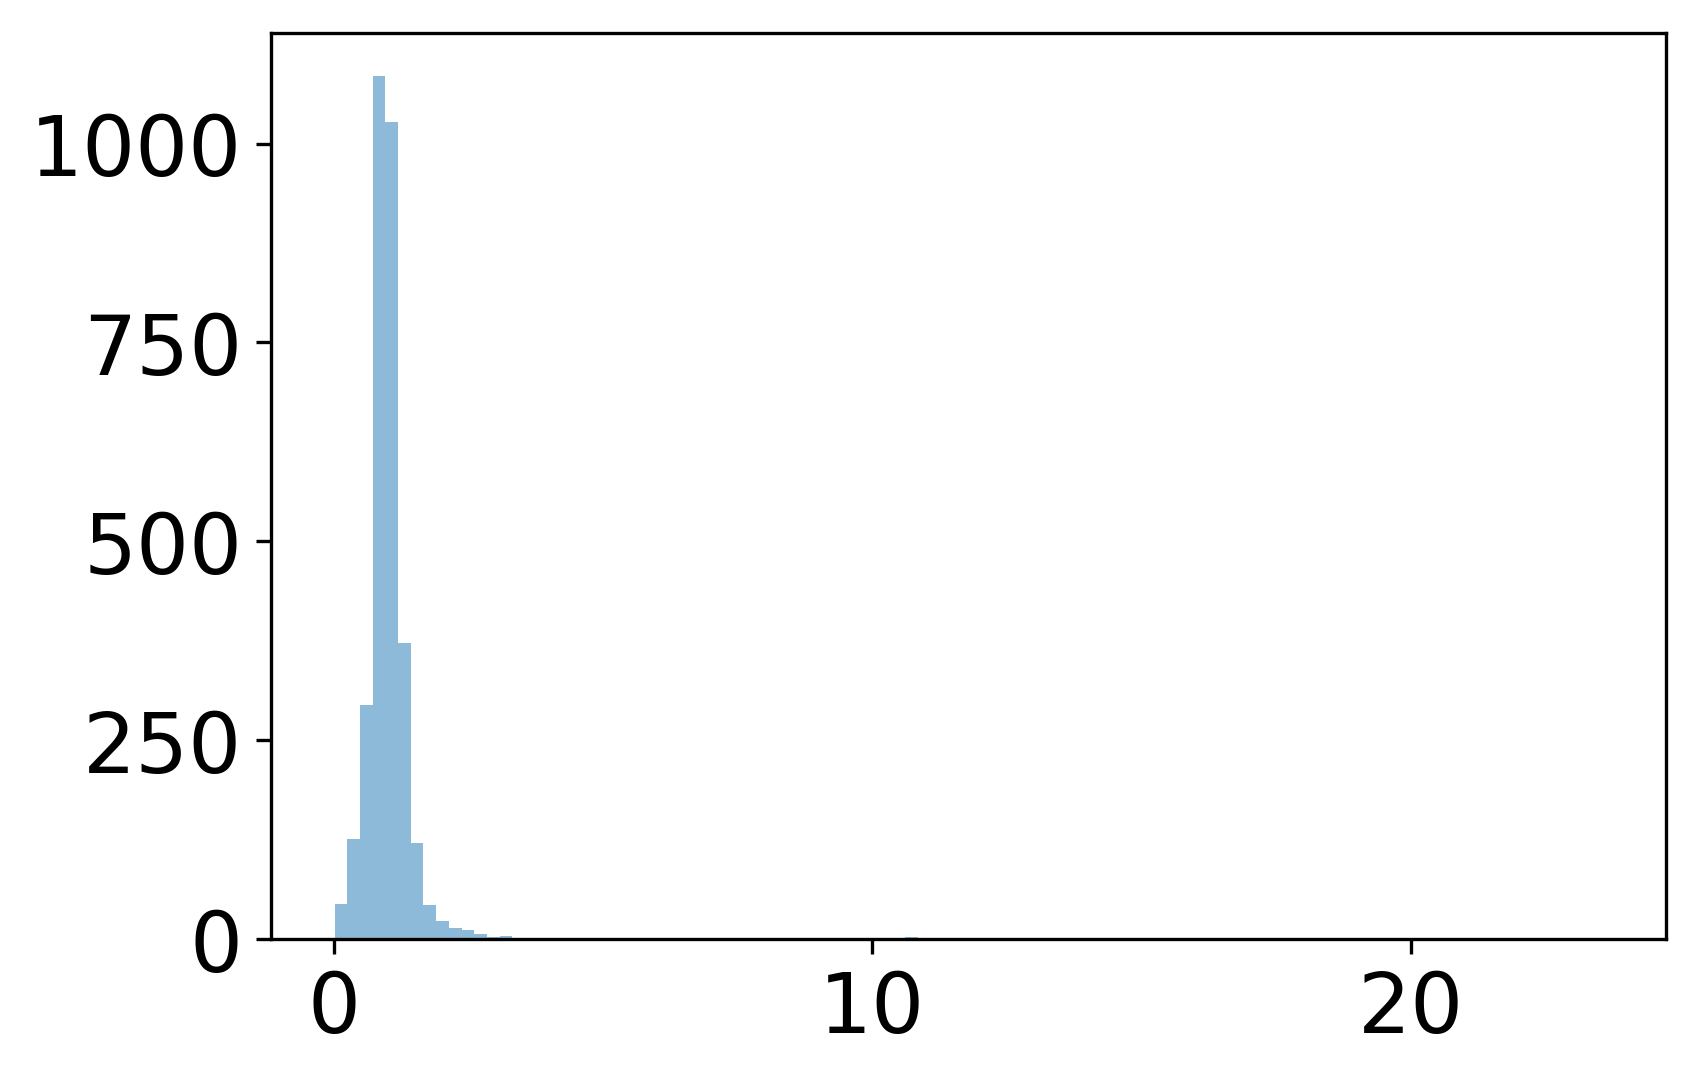

In [19]:
plt.hist(final_features.iloc[:,0], bins = 100, alpha = 0.5)

There is a remarkable outlier; the same happens for other features. 

But we could have also known from the difference between mean and median (which, in fact, is even more pronounced for orbital distance and period).

In [20]:
final_features.describe()

,S_MASS,P_PERIOD,P_DISTANCE
count,3180.000000,3.180000e+03,3180.000000
mean,1.018217,2.763531e+03,0.677663
std,0.649450,1.298246e+05,5.962161
min,0.020000,9.070629e-02,0.004408
25%,0.820000,4.175797e+00,0.050453
50%,0.970000,1.155546e+01,0.097369
75%,1.130000,5.474041e+01,0.274581
max,23.560000,7.300000e+06,243.000000


In [21]:
final_features = final_features[(np.abs(stats.zscore(final_features)) < 5).all(axis=1)] 

#This eliminates > 5 sigma outliers; however it counts from the mean so it might not be ideal

In [22]:
targets = targets[final_features.index]

### Now reset index.

In [23]:
final_features = final_features.reset_index(drop=True)

In [24]:
final_features.head()

,S_MASS,P_PERIOD,P_DISTANCE
0,2.70,326.03000,1.324418
1,2.78,516.21997,1.534896
2,2.20,185.84000,0.830000
3,0.90,1773.40000,3.130558
4,1.08,798.50000,2.043792


### And don't forget to do the same for the label vector.

In [25]:
targets = targets.reset_index(drop=True)

In [26]:
targets.head()

0    0
1    0
2    0
3    0
4    0
Name: P_HABITABLE, dtype: int64

### Comparing the shapes, we can see that 9 outliers were eliminated.

In [27]:
targets.shape

(3171,)

### Check balance of data set

In [ ]:
#Simple way: count 0/1s, get fraction of total

In [28]:
np.sum(targets)/len(targets)

0.01639861242510249

In [29]:
np.bincount(targets) #this shows the distribution of the two classes

array([3119,   52])

### This tells us that our data set is extremely imbalanced, and therefore, we need to be careful.

#### We can also just take a look at the first two features, using different symbols for the two classes.

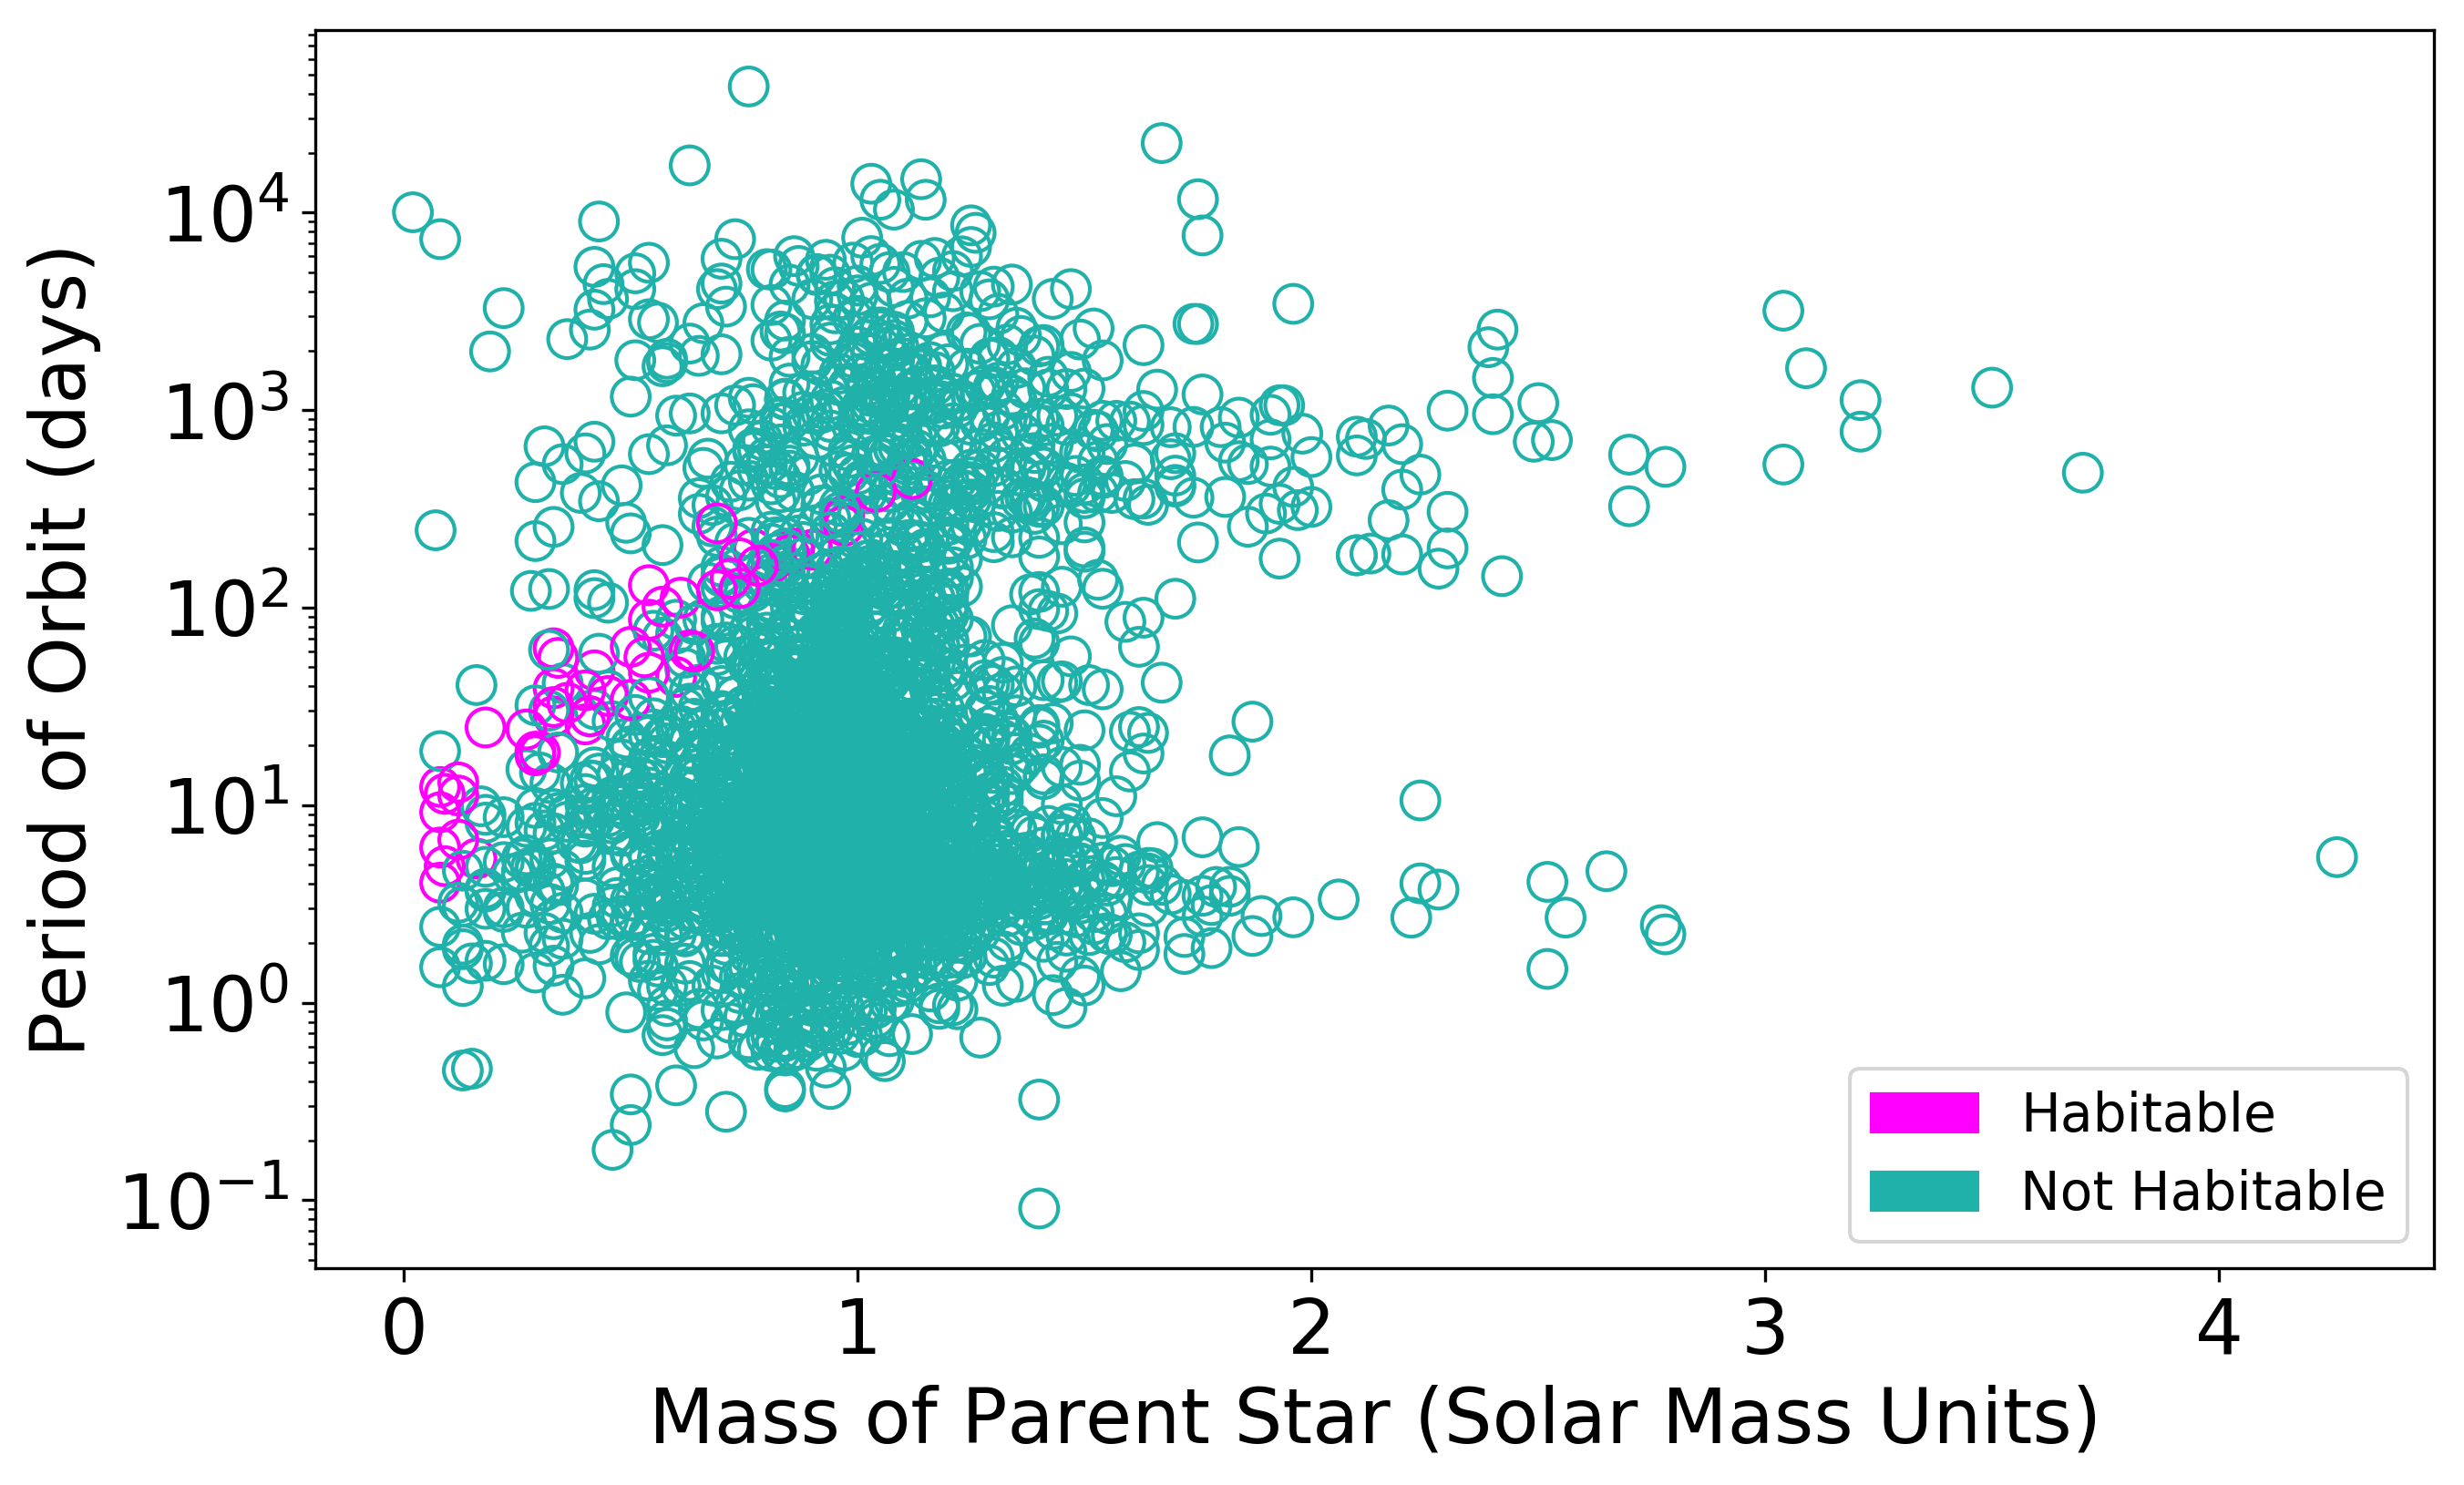

In [30]:
plt.figure(figsize=(10,6))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#20B2AA','#FF00FF'])

a = plt.scatter(final_features['S_MASS'], final_features['P_PERIOD'], marker = 'o',\
            c = targets, s = 100, cmap=cmap, label = 'Test')

plt.legend();

a.set_facecolor('none')

plt.yscale('log')
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)');

bluepatch = mpatches.Patch(color='#20B2AA', label='Not Habitable')
magentapatch = mpatches.Patch(color='#FF00FF', label='Habitable')

ax = plt.gca()
leg = ax.get_legend()

plt.legend(handles=[magentapatch, bluepatch],\
           loc = 'lower right', fontsize = 14);

### Questions: 

- Based on this graph, would you expect DT or kNN to perform better? Why?

Possibly kNN, because DT would only make splits along the features and cannot cut the data set diagonally. 
    
- What kind of performance can we expect (qualitatively, is the information sufficient?) Do you expect to have latent (hidden) variables that might affect the outcome beyond those that we have?

There is a lot of overlap between the two classes, which suggests that we can't expect a great performance unless we collect more features.

